# Preprocessing Notebook

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import cv2
import os
import shutil


from src.config import RAW_DATA_DIR, CONVERTED_DATA_DIR, PROCESSED_DATA_DIR
from src.preprocessing import Preprocessor

In [17]:
clinical_data_df = pd.read_excel(f'{RAW_DATA_DIR}/CMMD/CMMD_clinicaldata_revision.xlsx')
metadata_df = pd.read_csv(f'{RAW_DATA_DIR}/CMMD/metadata.csv')

In [18]:
metadata_df[metadata_df['Data Description URI'] == 'D2-0749'].iloc[0]['File Location']

'./CMMD/D2-0749/07-17-2012-NA-NA-85032/1.000000-NA-15082'

In [19]:
data_df = clinical_data_df[clinical_data_df['subtype'].notnull()]

In [20]:
data_df.shape

(749, 7)

In [21]:
# Merge dataframes
data_df = data_df.merge(metadata_df, left_on='ID1', right_on='Data Description URI')

In [22]:
data_df.head()

,ID1,LeftRight,Age,number,abnormality,classification,subtype,Series UID,Collection,3rd Party Analysis,...,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp
0,D2-0001,L,64,2,calcification,Malignant,Luminal B,CMMD,NO,https://doi.org/10.7937/tcia.eqde4b16,...,NaN,NaN,MG,Digital Mammography X-Ray Image Storage - For ...,1.2.840.10008.5.1.4.1.1.1.2,4,17,57 MB,./CMMD/D2-0001/07-18-2011-NA-NA-75485/1.000000...,2025-02-27T01:46:30.766
1,D2-0002,R,69,2,calcification,Malignant,Luminal B,CMMD,NO,https://doi.org/10.7937/tcia.eqde4b16,...,NaN,NaN,MG,Digital Mammography X-Ray Image Storage - For ...,1.2.840.10008.5.1.4.1.1.1.2,4,17,57 MB,./CMMD/D2-0002/07-18-2010-NA-NA-26354/1.000000...,2025-02-27T01:46:30.945
2,D2-0003,L,44,2,calcification,Malignant,Luminal B,CMMD,NO,https://doi.org/10.7937/tcia.eqde4b16,...,NaN,NaN,MG,Digital Mammography X-Ray Image Storage - For ...,1.2.840.10008.5.1.4.1.1.1.2,4,17,57 MB,./CMMD/D2-0003/07-18-2010-NA-NA-57046/1.000000...,2025-02-27T01:46:37.61
3,D2-0004,L,38,2,calcification,Malignant,Luminal B,CMMD,NO,https://doi.org/10.7937/tcia.eqde4b16,...,NaN,NaN,MG,Digital Mammography X-Ray Image Storage - For ...,1.2.840.10008.5.1.4.1.1.1.2,4,17,57 MB,./CMMD/D2-0004/07-18-2010-NA-NA-29234/1.000000...,2025-02-27T01:46:35.712
4,D2-0005,R,41,2,calcification,Malignant,HER2-enriched,CMMD,NO,https://doi.org/10.7937/tcia.eqde4b16,...,NaN,NaN,MG,Digital Mammography X-Ray Image Storage - For ...,1.2.840.10008.5.1.4.1.1.1.2,4,17,57 MB,./CMMD/D2-0005/07-18-2010-NA-NA-26051/1.000000...,2025-02-27T01:46:34.88


In [23]:
data_df = data_df[['ID1', 'LeftRight', 'Age', 'abnormality', 'subtype', 'File Location']]

In [24]:
data_df.head()

,ID1,LeftRight,Age,abnormality,subtype,File Location
0,D2-0001,L,64,calcification,Luminal B,./CMMD/D2-0001/07-18-2011-NA-NA-75485/1.000000...
1,D2-0002,R,69,calcification,Luminal B,./CMMD/D2-0002/07-18-2010-NA-NA-26354/1.000000...
2,D2-0003,L,44,calcification,Luminal B,./CMMD/D2-0003/07-18-2010-NA-NA-57046/1.000000...
3,D2-0004,L,38,calcification,Luminal B,./CMMD/D2-0004/07-18-2010-NA-NA-29234/1.000000...
4,D2-0005,R,41,calcification,HER2-enriched,./CMMD/D2-0005/07-18-2010-NA-NA-26051/1.000000...


In [25]:
data_df.rename(columns={'ID1': 'patientId', 'LeftRight': 'malignantSide', 'Age': 'age', 'File Location': 'originalPath'}, inplace=True)

In [26]:
data_df['subtype'].value_counts()

subtype
Luminal B          376
Luminal A          152
HER2-enriched      135
triple negative     86
Name: count, dtype: int64

In [27]:
data_df['subtype'] = data_df['subtype'].map({'Luminal B': 'luminal-b', 'Luminal A': 'luminal-a', 'HER2-enriched': 'her2-enriched', 'triple negative': 'triple-negative'})

In [28]:
data_df.head()

,patientId,malignantSide,age,abnormality,subtype,originalPath
0,D2-0001,L,64,calcification,luminal-b,./CMMD/D2-0001/07-18-2011-NA-NA-75485/1.000000...
1,D2-0002,R,69,calcification,luminal-b,./CMMD/D2-0002/07-18-2010-NA-NA-26354/1.000000...
2,D2-0003,L,44,calcification,luminal-b,./CMMD/D2-0003/07-18-2010-NA-NA-57046/1.000000...
3,D2-0004,L,38,calcification,luminal-b,./CMMD/D2-0004/07-18-2010-NA-NA-29234/1.000000...
4,D2-0005,R,41,calcification,her2-enriched,./CMMD/D2-0005/07-18-2010-NA-NA-26051/1.000000...


In [29]:
data_df['originalPath'] = data_df['originalPath'].str.replace('./CMMD/', 'images/')

In [30]:
data_df.head()

,patientId,malignantSide,age,abnormality,subtype,originalPath
0,D2-0001,L,64,calcification,luminal-b,images/D2-0001/07-18-2011-NA-NA-75485/1.000000...
1,D2-0002,R,69,calcification,luminal-b,images/D2-0002/07-18-2010-NA-NA-26354/1.000000...
2,D2-0003,L,44,calcification,luminal-b,images/D2-0003/07-18-2010-NA-NA-57046/1.000000...
3,D2-0004,L,38,calcification,luminal-b,images/D2-0004/07-18-2010-NA-NA-29234/1.000000...
4,D2-0005,R,41,calcification,her2-enriched,images/D2-0005/07-18-2010-NA-NA-26051/1.000000...


In [31]:
data_df['originalPath'] = data_df['originalPath'].str.replace('images/', '../data/raw/CMMD/images/')

In [32]:
data_df.head()

,patientId,malignantSide,age,abnormality,subtype,originalPath
0,D2-0001,L,64,calcification,luminal-b,../data/raw/CMMD/images/D2-0001/07-18-2011-NA-...
1,D2-0002,R,69,calcification,luminal-b,../data/raw/CMMD/images/D2-0002/07-18-2010-NA-...
2,D2-0003,L,44,calcification,luminal-b,../data/raw/CMMD/images/D2-0003/07-18-2010-NA-...
3,D2-0004,L,38,calcification,luminal-b,../data/raw/CMMD/images/D2-0004/07-18-2010-NA-...
4,D2-0005,R,41,calcification,her2-enriched,../data/raw/CMMD/images/D2-0005/07-18-2010-NA-...


In [33]:
data_df_11 = data_df.copy()
data_df_11['originalPath'] = data_df_11['originalPath'] + '/1-1.dcm'
data_df_11 = data_df_11[data_df_11['originalPath'].apply(os.path.exists)]
data_df_11['view'] = 'CC'

data_df_12 = data_df.copy()
data_df_12['originalPath'] = data_df_12['originalPath'] + '/1-2.dcm'
data_df_12 = data_df_12[data_df_12['originalPath'].apply(os.path.exists)]
data_df_12['view'] = 'MLO'

data_df_13 = data_df.copy()
data_df_13['originalPath'] = data_df_13['originalPath'] + '/1-3.dcm'
data_df_13 = data_df_13[data_df_13['originalPath'].apply(os.path.exists)]
data_df_13['view'] = 'CC'

data_df_14 = data_df.copy()
data_df_14['originalPath'] = data_df_14['originalPath'] + '/1-4.dcm'
data_df_14 = data_df_14[data_df_14['originalPath'].apply(os.path.exists)]
data_df_14['view'] = 'MLO'

cmmd = pd.concat([data_df_11, data_df_12, data_df_13, data_df_14])

In [85]:
cmmd.query('patientId == "D2-0678"')

,patientId,malignantSide,age,abnormality,subtype,originalPath,view,laterality
677,D2-0678,L,74,mass,luminal-b,../data/raw/CMMD/images/D2-0678/07-18-2011-NA-...,CC,L
677,D2-0678,L,74,mass,luminal-b,../data/raw/CMMD/images/D2-0678/07-18-2011-NA-...,MLO,L
677,D2-0678,L,74,mass,luminal-b,../data/raw/CMMD/images/D2-0678/07-18-2011-NA-...,CC,R
677,D2-0678,L,74,mass,luminal-b,../data/raw/CMMD/images/D2-0678/07-18-2011-NA-...,MLO,R


In [35]:
# Fix laterality and view
for i, row in cmmd.iterrows():
    if '1-3.dcm' in row['originalPath']:
        patientID = row['patientId']
        cmmd.loc[(cmmd['patientId'] == patientID) & (cmmd['originalPath'].str.contains('1-1.dcm')), 'laterality'] = 'L'
        cmmd.loc[(cmmd['patientId'] == patientID) & (
            cmmd['originalPath'].str.contains('1-2.dcm')), 'laterality'] = 'L'
        cmmd.loc[(cmmd['patientId'] == patientID) & (
            cmmd['originalPath'].str.contains('1-1.dcm')), 'view'] = 'CC'
        cmmd.loc[(cmmd['patientId'] == patientID) & (
            cmmd['originalPath'].str.contains('1-2.dcm')), 'view'] = 'MLO'
        cmmd.loc[(cmmd['patientId'] == patientID) & (
            cmmd['originalPath'].str.contains('1-3.dcm')), 'laterality'] = 'R'
        cmmd.loc[(cmmd['patientId'] == patientID) & (
            cmmd['originalPath'].str.contains('1-3.dcm')), 'view'] = 'CC'
        cmmd.loc[(cmmd['patientId'] == patientID) & (
            cmmd['originalPath'].str.contains('1-4.dcm')), 'laterality'] = 'R'
        cmmd.loc[(cmmd['patientId'] == patientID) & (
            cmmd['originalPath'].str.contains('1-4.dcm')), 'view'] = 'MLO'

In [36]:
cmmd['laterality'] = cmmd['laterality'].fillna(cmmd['malignantSide'])

In [37]:
cmmd.shape

(2988, 8)

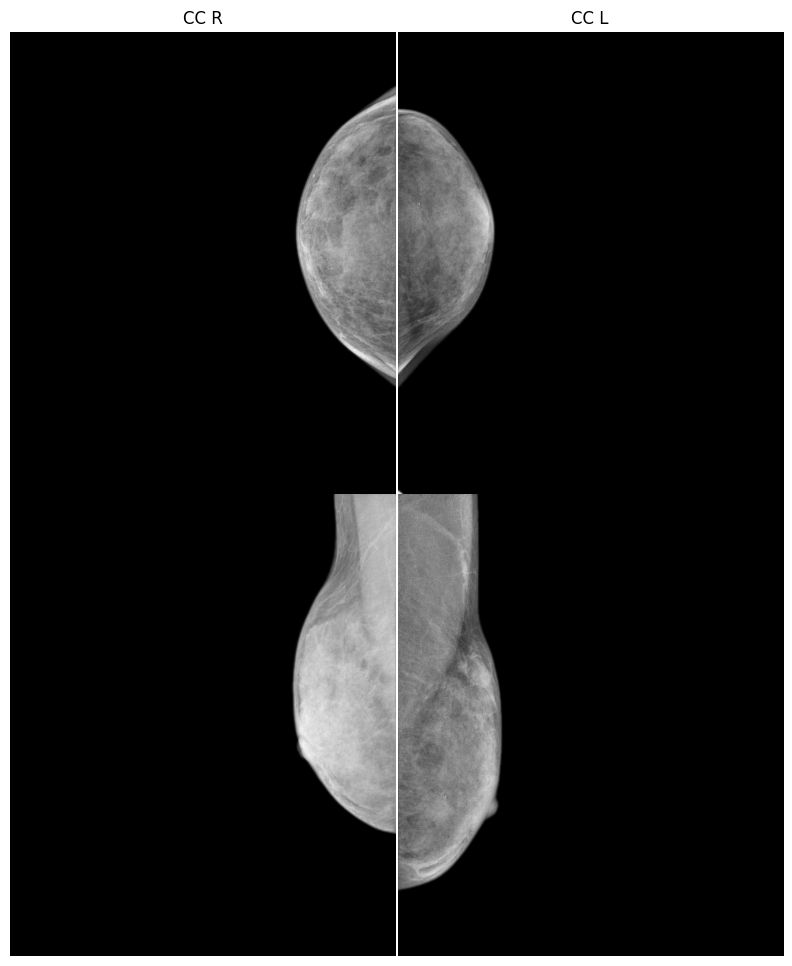

In [83]:
import matplotlib.gridspec as gridspec

img1 = pydicom.dcmread('../data/raw/CMMD/images/D2-0013/07-18-2010-NA-NA-03314/1.000000-NA-85960/1-1.dcm')
img2 = pydicom.dcmread('../data/raw/CMMD/images/D2-0013/07-18-2010-NA-NA-03314/1.000000-NA-85960/1-2.dcm')
img3 = pydicom.dcmread('../data/raw/CMMD/images/D2-0013/07-18-2010-NA-NA-03314/1.000000-NA-85960/1-3.dcm')
img4 = pydicom.dcmread('../data/raw/CMMD/images/D2-0013/07-18-2010-NA-NA-03314/1.000000-NA-85960/1-4.dcm')

fig = plt.figure(figsize=(10, 12))

# create 2x2 grid

gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0, hspace=0)

axs = [[fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])],
         [fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])]]
# plot images


axs[0][0].imshow(img3.pixel_array, cmap='gray')
axs[0][0].set_title('CC R')
axs[0][0].axis('off')
axs[0][1].imshow(img1.pixel_array, cmap='gray')
axs[0][1].set_title('CC L')
axs[0][1].axis('off')

axs[1][0].imshow(img4.pixel_array, cmap='gray')
axs[1][0].set_title('CC R')
axs[1][0].axis('off')
axs[1][1].imshow(img2.pixel_array, cmap='gray')
axs[1][1].set_title('CC L')
axs[1][1].axis('off')

plt.show()

In [38]:
cmmd_filtered = cmmd[cmmd['laterality'] == cmmd['malignantSide']]
cmmd_filtered.shape

(1498, 8)

In [24]:
cmmd_filtered.query('patientId == "D2-0402"')

,patientId,malignantSide,age,abnormality,subtype,originalPath,view,laterality
401,D2-0402,R,49,mass,luminal-a,../data/raw/CMMD/images/D2-0402/07-18-2010-NA-...,CC,R
401,D2-0402,R,49,mass,luminal-a,../data/raw/CMMD/images/D2-0402/07-18-2010-NA-...,MLO,R


In [25]:
patient = cmmd_filtered.query('patientId == "D2-0026"')
patient

,patientId,malignantSide,age,abnormality,subtype,originalPath,view,laterality
25,D2-0026,L,46,calcification,luminal-b,../data/raw/CMMD/images/D2-0026/07-18-2010-NA-...,CC,L
25,D2-0026,L,46,calcification,luminal-b,../data/raw/CMMD/images/D2-0026/07-18-2010-NA-...,MLO,L


In [26]:
dcm = pydicom.dcmread(patient.iloc[0]['originalPath'])
dcm.ImageLaterality

'L'

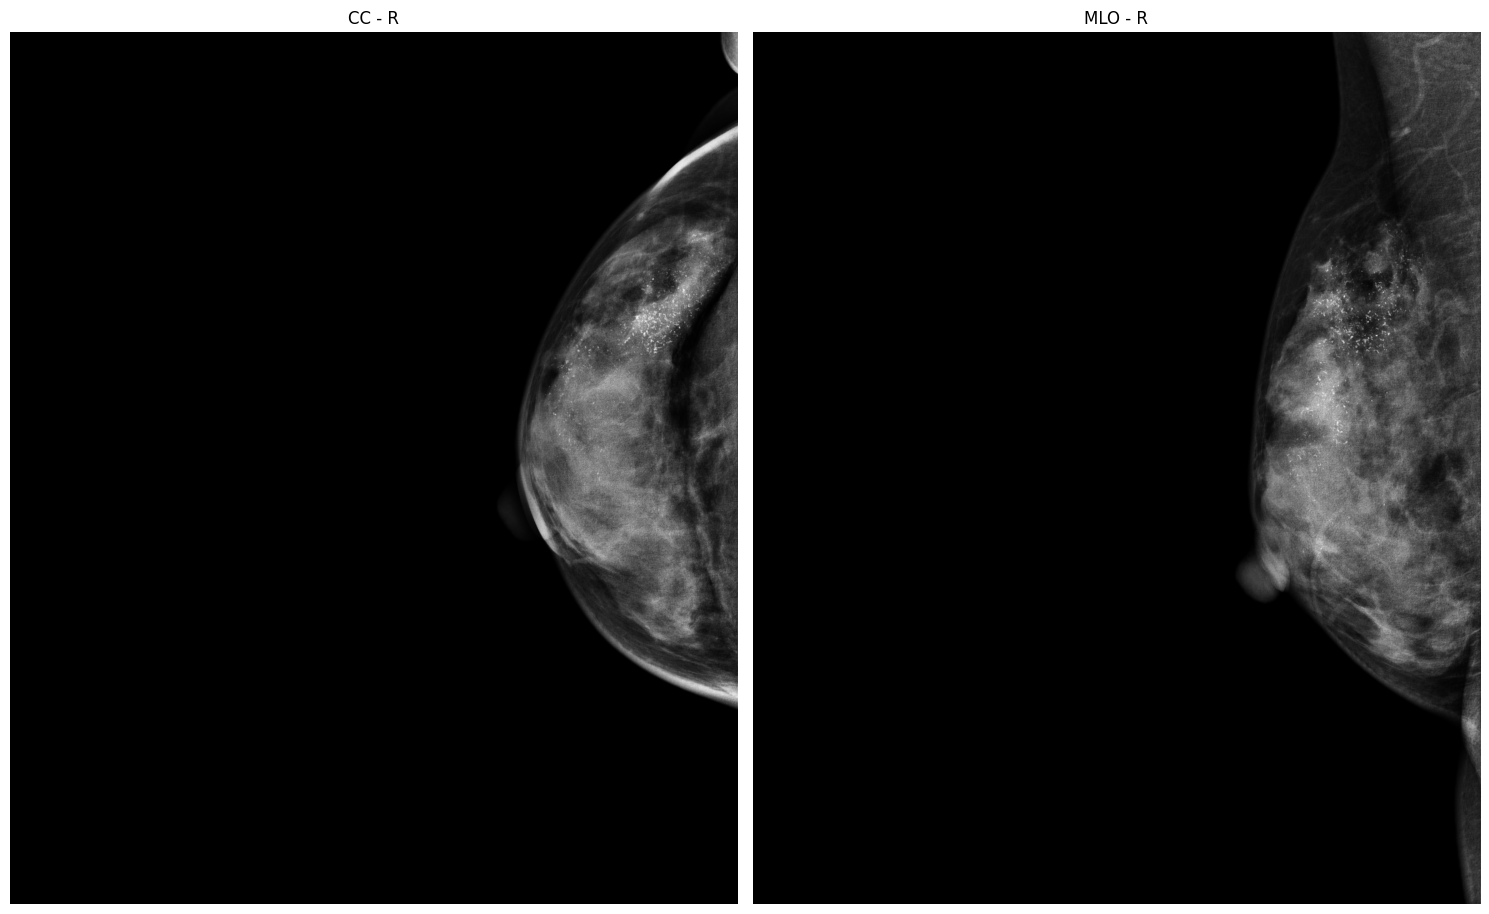

In [27]:
example_patient = cmmd_filtered.query('patientId == "D2-0010"')
# subplot for each view
fig, axs = plt.subplots(1, 2, figsize=(15, 15))
index = 0
for i, row in example_patient.iterrows():
    dcm = pydicom.dcmread(row['originalPath'])
    axs[index].imshow(dcm.pixel_array, cmap='gray')
    axs[index].set_title(f'{row["view"]} - {row["laterality"]}')
    axs[index].axis('off')
    index += 1
plt.tight_layout()
plt.show()

# 2. Preprocessing Pipeline and functions

In [28]:
preprocessor = Preprocessor()

## 2.1 Crop Image ROI

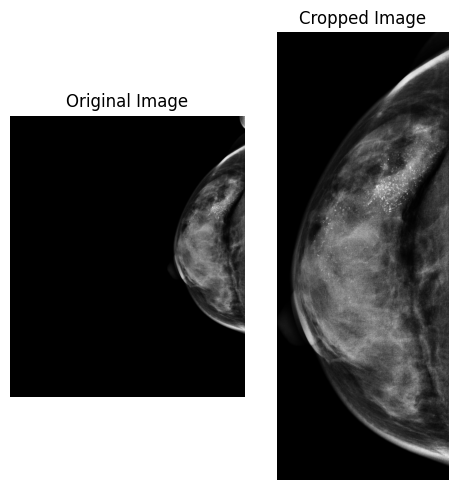

In [29]:
dcm = pydicom.dcmread(example_patient.iloc[0]['originalPath'])
img = dcm.pixel_array
cropped_img = preprocessor.crop_image_roi(image=img, additional_margin=50)

fig, axs = plt.subplots(1, 2, figsize=(5, 5),)
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(cropped_img, cmap='gray')
axs[1].set_title('Cropped Image')
axs[1].axis('off')

plt.tight_layout()
plt.show()

## 2.2 Median Filter and Normalization

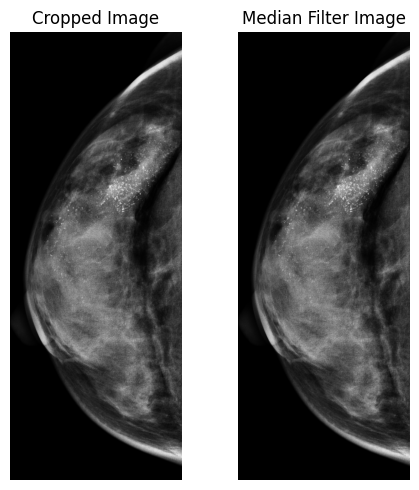

In [35]:
median_img = preprocessor.median_filter(cropped_img, kernel_size=1)

fig, axs = plt.subplots(1, 2, figsize=(5, 5),)
axs[0].imshow(cropped_img, cmap='gray')
axs[0].set_title('Cropped Image')
axs[0].axis('off')

axs[1].imshow(median_img, cmap='gray')
axs[1].set_title('Median Filter Image')
axs[1].axis('off')

plt.tight_layout()
plt.show()

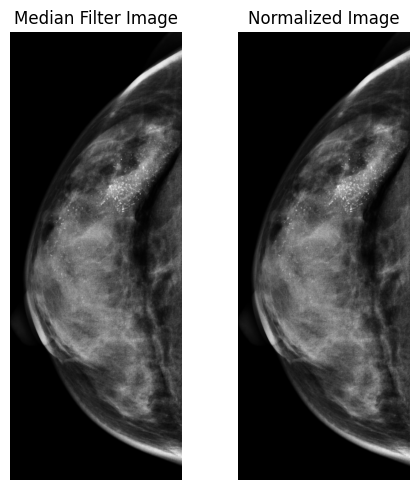

In [31]:
normalized_img = preprocessor.normalize(median_img)

fig, axs = plt.subplots(1, 2, figsize=(5, 5),)
axs[0].imshow(median_img, cmap='gray')
axs[0].set_title('Median Filter Image')
axs[0].axis('off')

axs[1].imshow(normalized_img, cmap='gray')
axs[1].set_title('Normalized Image')
axs[1].axis('off')

plt.tight_layout()
plt.show()

## 2.3 Apply CLAHE

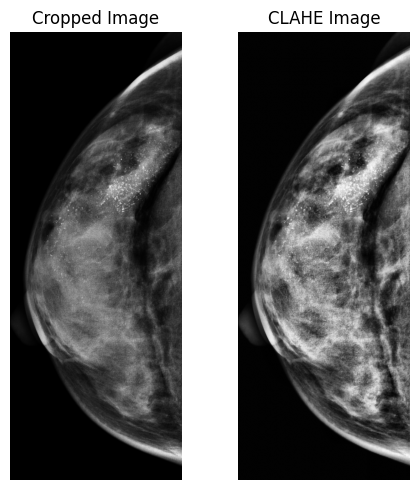

In [32]:
clahe_img = preprocessor.apply_clahe(normalized_img)

fig, axs = plt.subplots(1, 2, figsize=(5, 5),)
axs[0].imshow(cropped_img, cmap='gray')
axs[0].set_title('Cropped Image')
axs[0].axis('off')

axs[1].imshow(clahe_img, cmap='gray')
axs[1].set_title('CLAHE Image')
axs[1].axis('off')

plt.tight_layout()

plt.show()

# 3. Preprocess all images

In [36]:
cmmd_converted = cmmd_filtered.copy()
cmmd_converted['convertedPath'] = ''

In [37]:
cmmd_converted.head()

,patientId,malignantSide,age,abnormality,subtype,originalPath,view,laterality,convertedPath
0,D2-0001,L,64,calcification,luminal-b,../data/raw/CMMD/images/D2-0001/07-18-2011-NA-...,CC,L,
2,D2-0003,L,44,calcification,luminal-b,../data/raw/CMMD/images/D2-0003/07-18-2010-NA-...,CC,L,
3,D2-0004,L,38,calcification,luminal-b,../data/raw/CMMD/images/D2-0004/07-18-2010-NA-...,CC,L,
11,D2-0012,L,32,calcification,her2-enriched,../data/raw/CMMD/images/D2-0012/07-18-2010-NA-...,CC,L,
12,D2-0013,L,57,calcification,triple-negative,../data/raw/CMMD/images/D2-0013/07-18-2010-NA-...,CC,L,


In [38]:
if os.path.exists(CONVERTED_DATA_DIR):
    shutil.rmtree(CONVERTED_DATA_DIR)

index = 0
for i, row in cmmd_converted.iterrows():
    dcm = pydicom.dcmread(row['originalPath'])
    img = dcm.pixel_array
    processed_img = preprocessor.preprocess_image(image=img, additional_margin=25)

    patient_folder = os.path.join(CONVERTED_DATA_DIR, row['patientId'])
    os.makedirs(patient_folder, exist_ok=True)

    image_name = f'{row["view"]}-{row["malignantSide"]}.png'

    cmmd_converted.iloc[index, cmmd_converted.columns.get_loc('convertedPath')] = os.path.join(patient_folder,image_name)
    cv2.imwrite(os.path.join(patient_folder, image_name), processed_img)
    index += 1

In [39]:
cmmd_filtered.head()

,patientId,malignantSide,age,abnormality,subtype,originalPath,view,laterality
0,D2-0001,L,64,calcification,luminal-b,../data/raw/CMMD/images/D2-0001/07-18-2011-NA-...,CC,L
2,D2-0003,L,44,calcification,luminal-b,../data/raw/CMMD/images/D2-0003/07-18-2010-NA-...,CC,L
3,D2-0004,L,38,calcification,luminal-b,../data/raw/CMMD/images/D2-0004/07-18-2010-NA-...,CC,L
11,D2-0012,L,32,calcification,her2-enriched,../data/raw/CMMD/images/D2-0012/07-18-2010-NA-...,CC,L
12,D2-0013,L,57,calcification,triple-negative,../data/raw/CMMD/images/D2-0013/07-18-2010-NA-...,CC,L


In [40]:
cmmd_converted.head()

,patientId,malignantSide,age,abnormality,subtype,originalPath,view,laterality,convertedPath
0,D2-0001,L,64,calcification,luminal-b,../data/raw/CMMD/images/D2-0001/07-18-2011-NA-...,CC,L,/Users/dacxjo/TFG/data/processed/converted/D2-...
2,D2-0003,L,44,calcification,luminal-b,../data/raw/CMMD/images/D2-0003/07-18-2010-NA-...,CC,L,/Users/dacxjo/TFG/data/processed/converted/D2-...
3,D2-0004,L,38,calcification,luminal-b,../data/raw/CMMD/images/D2-0004/07-18-2010-NA-...,CC,L,/Users/dacxjo/TFG/data/processed/converted/D2-...
11,D2-0012,L,32,calcification,her2-enriched,../data/raw/CMMD/images/D2-0012/07-18-2010-NA-...,CC,L,/Users/dacxjo/TFG/data/processed/converted/D2-...
12,D2-0013,L,57,calcification,triple-negative,../data/raw/CMMD/images/D2-0013/07-18-2010-NA-...,CC,L,/Users/dacxjo/TFG/data/processed/converted/D2-...


In [43]:
cmmd_converted.to_csv(f'{PROCESSED_DATA_DIR}/cmmd_converted.csv', index=False)